### Temporal Convolutional Network (TCN) for sequence modeling
[An empirical evaluation of generic convolutional and recurrent networks for sequence modeling](https://arxiv.org/abs/1803.01271)

Copied code from [Github](https://github.com/locuslab/TCN/blob/master/TCN/tcn.py)

In [1]:
from fastai.text import *
sys.path.append(f'./auxillary')
from auxillary.lm_tcn import *

### Load data

In [2]:
PATH = Path('/home/odenigborig/Data/wikitext-2')
int2str = pickle.load(open(PATH/'tmp'/'int2str.pkl','rb'))
train_ids = np.load(PATH/'tmp'/'train_ids.npy')
valid_ids = np.load(PATH/'tmp'/'valid_ids.npy')
test_ids = np.load(PATH/'tmp'/'test_ids.npy')
vocab_size = len(int2str);vocab_size

33279

temporal convolution (residual) block consists of two layers of:
- Dilated causal convolution (kernel size = 3)
- WeightNorm
- ReLU
- Dropout

Followed by conditional 1x1 convolution to ensure element-wise addition of block output and input are the same shape.

Weights are randomly initialized from Guassian distribution N(0,1)

According to the paper, for word level language modeling, the authors used the following parameters (wiki-103):
- embedding size: 400 
- kernel size: 3
- hidden units: 1000
- residual blocks: 5
- dropout: 0.4
- gradient clipping: 0.4

In [3]:
bs = 64
seq_len = 100 #samples to process simultaneously
vocab_size = 33279

emb_size = 400
nhidden_units = 1000
nlevels = 4
kernel_size=3
dropoute=0.1 #embedding layer dropout
dropoutc=0.2 #residual layer dropout
dropoutd=0.1 #decoder layer dropout

drops = np.array([dropoute,dropoutc,dropoutd])*0.7

## Run LR_find

Run `LR_find` under the same conditions that you would run 
Parameter search:
- ~~batch size~~
- ~~weight decay~~
- sequence length
- dropout
    - try spatial dropout...

In [4]:
def run_LR_find(bs=64,seq_len=100,clip=0.4,nlevels=4,weight_decay=1e-5,tie_weight=True,\
                end_lr=1000,start_lr=1e-2,plot=True,drops=drops):
    
    train_dl = TCNLanguageModelDataLoader(np.concatenate(train_ids),bs,seq_len)
    valid_dl = TCNLanguageModelDataLoader(np.concatenate(valid_ids),bs,seq_len)

    nhid_list = [nhidden_units]*(nlevels-1) + [emb_size]
    ksize = 3 #kernel size
    
    print('Loading model...')
    model = TCNLanguageModelData(PATH,vocab_size,train_dl,valid_dl)
    opt_fn = partial(optim.SGD,momentum=0.95)
    learner = model.get_model(opt_fn,emb_size,nhid_list,tie_weights=tie_weight,
                              dropoute=drops[0],dropoutc=drops[1],dropoutd=drops[2])
    learner.clip = clip
    learner.metrics = [accuracy]
    #learner.crit = tcn_cross_entropy
    
    print('Running LR_find...')
    learner.unfreeze()
    learner.lr_find(wds=weight_decay,end_lr=end_lr,start_lr=start_lr)
    
    if plot: learner.sched.plot()
    
    return learner

In [5]:
torch.cuda.empty_cache()

### Weight decay

In [6]:
wds = [0,1e-5,1e-6,1e-7]
lrs = []
trn_losses = []
val_losses = []
best_lrs = []

for wd in wds:
    print('Weight decay: {}'.format(wd))
    learner = run_LR_find(bs=64,seq_len=80,weight_decay=wd,plot=False)
    
    lrs.append(learner.sched.lrs)
    trn_losses.append(learner.sched.losses)
    val_losses.append(learner.sched.val_losses)
    best_lrs.append(learner.sched.best)
    
    torch.cuda.empty_cache()    
    print('')

Weight decay: 0
Loading model...
Tied weights
Running LR_find...


 66%|██████▌   | 267/407 [00:53<00:28,  4.98it/s, loss=146] 
Weight decay: 1e-05
Loading model...
Tied weights
Running LR_find...


 67%|██████▋   | 272/407 [00:55<00:27,  4.90it/s, loss=33.1]
Weight decay: 1e-06
Loading model...
Tied weights
Running LR_find...


 73%|███████▎  | 296/407 [01:00<00:22,  4.89it/s, loss=434] 
Weight decay: 1e-07
Loading model...
Tied weights
Running LR_find...


 67%|██████▋   | 274/407 [00:55<00:27,  4.91it/s, loss=62.6]


(7.5, 12)

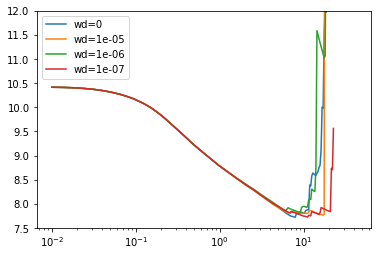

In [9]:
fig,ax = plt.subplots(1,1)
for p in range(len(wds)):
    ax.plot(lrs[p],trn_losses[p],label='wd='+str(wds[p]))

ax.set_xscale('log')
ax.legend()
ax.set_ylim(7.5, 12)

Other tests to run: 
- dropouts
- increased levels
- sequence length

In [ ]:
%debug

In [5]:
wds = [0,1e-4,1e-5,1e-6,1e-7]
lrs = []
trn_losses = []
val_losses = []
best_lrs = []

for wd in wds:
    print('Weight decay: {}'.format(wd))
    learner = run_LR_find(bs=64,seq_len=80,weight_decay=wd,clip=0.1,plot=False)
    
    lrs.append(learner.sched.lrs)
    trn_losses.append(learner.sched.losses)
    val_losses.append(learner.sched.val_losses)
    best_lrs.append(learner.sched.best)
    
    torch.cuda.empty_cache()    
    print('')

Weight decay: 0
Loading model...
Tied weights
Running LR_find...


 80%|████████  | 327/407 [01:05<00:15,  5.00it/s, loss=9.24e+03]
Weight decay: 0.0001
Loading model...
Tied weights
Running LR_find...


 79%|███████▉  | 323/407 [01:06<00:17,  4.89it/s, loss=30.5]
Weight decay: 1e-05
Loading model...
Tied weights
Running LR_find...


 75%|███████▌  | 306/407 [01:02<00:20,  4.89it/s, loss=35.5]
Weight decay: 1e-06
Loading model...
Tied weights
Running LR_find...


 77%|███████▋  | 312/407 [01:03<00:19,  4.89it/s, loss=34.7]
Weight decay: 1e-07
Loading model...
Tied weights
Running LR_find...


 76%|███████▌  | 310/407 [01:03<00:19,  4.89it/s, loss=75.6]


(7, 12)

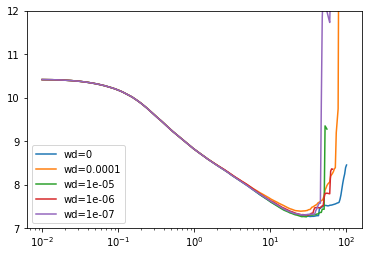

In [8]:
fig,ax = plt.subplots(1,1)
for p in range(len(wds)):
    ax.plot(lrs[p],trn_losses[p],label='wd='+str(wds[p]))

ax.set_xscale('log')
ax.legend()
ax.set_ylim(7, 12)

In [6]:
learner

Sequential(
  (0): TCN_Encoder(
    (encoder): Embedding(33279, 400)
    (dropoute): Dropout(p=0.06999999999999999, inplace)
    (tcn_module): TemporalConvModule(
      (tcn_module): Sequential(
        (0): BasicTempConvBlock(
          (conv1): Conv1d(400, 1000, kernel_size=(3,), stride=(1,), padding=(2,), bias=False)
          (chop1): Chop1d(
          )
          (relu1): ReLU(inplace)
          (dropout1): Dropout(p=0.13999999999999999, inplace)
          (conv2): Conv1d(1000, 1000, kernel_size=(3,), stride=(1,), padding=(2,), bias=False)
          (chop2): Chop1d(
          )
          (relu2): ReLU(inplace)
          (dropout2): Dropout(p=0.13999999999999999, inplace)
          (downsample): Conv1d(400, 1000, kernel_size=(1,), stride=(1,), bias=False)
          (relu3): ReLU(inplace)
        )
        (1): BasicTempConvBlock(
          (conv1): Conv1d(1000, 1000, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,), bias=False)
          (chop1): Chop1d(
          )
     

## Evaluation

Have to calculate loss on "effective history". The effective history is calculated per layer as:

\begin{equation}
(k-1)*d
\end{equation}

where `k` is the kernel size and `d` is the dilation factor. 

For evaluation discard the effective history and compute loss on 

In [9]:
eff_history = np.sum([(2*(kernel_size-1)*d) for d in range(1,nlevels+1)])
loss = nn.CrossEntropyLoss()

def evaluate(learner,source=None):
    model = learner.model
    model.eval()
    
    if source is None: source = learner.data.val_dl
    
    total_loss = 0.
    eval_data_len = 0
    #pdb.set_trace()

    for data, targets in tqdm(source):
        seq_len = data.size(1)
        output = model(V(data))  #run inference on data.
        output = output.view(-1,seq_len,vocab_size)  #delete this later, reshape into batch_size x seq_len x vocab_size
        final_output = output[:,eff_history:].contiguous().view(-1,vocab_size) #resize to  samples x vocab_size
        target = targets.contiguous().view(-1,seq_len) #delete this later
        final_target = target[:,eff_history:].contiguous().view(-1) #flatten - each sample represents the class (or vocab word)
        
        batch_loss = loss(final_output,V(final_target))
        
        batch_len = data.size(1) - eff_history
        total_loss += batch_len * batch_loss.data
        eval_data_len += batch_len
        
    mean = total_loss[0] / eval_data_len
    return mean,np.exp(mean) #loss, perplexity
        

In [10]:
def run_Learner(bs=64,seq_len=100,clip=0.4,nlevels=4,tie_weight=True):
    
    train_dl = TCNLanguageModelDataLoader(np.concatenate(train_ids),bs,seq_len)
    valid_dl = TCNLanguageModelDataLoader(np.concatenate(valid_ids),bs,seq_len)

    nhid_list = [nhidden_units]*(nlevels-1) + [emb_size]
    ksize = 3 #kernel size
    #eff_history = np.sum([(2*(ksize-1)*d) for d in range(1,nlevels+1)])
    
    print('Loading model...')
    model = TCNLanguageModelData(PATH,vocab_size,train_dl,valid_dl)
    opt_fn = partial(optim.SGD,momentum=0.95)
    learner = model.get_model(opt_fn,emb_size,nhid_list,tie_weights=tie_weight,dropoute=drops[0],dropoutc=drops[1],dropoutd=drops[2])
    learner.unfreeze()
    
    learner.clip = clip
    learner.metrics = [accuracy]
    #learner.crit = tcn_cross_entropy
    print('Done loading.')
    return learner

In [14]:
def plot_losses():
    epochs = len(learner.sched.val_losses)
    its = len(learner.sched.losses) #iterations
    ipe = its//epochs #iterations per epoch
    #grab the loss at the end of each epoch.
    trn_losses = [learner.sched.losses[i] for i in range(ipe-1,its,ipe)]

    fig,ax = plt.subplots(1,1,figsize=(6,4))
    ax.plot(trn_losses,label='train')
    ax.plot(learner.sched.val_losses,label='valid')
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    ax.legend()

In [12]:
weight_decay = 1e-7
seq_len=80
LRs = [1,3,10]

In [15]:
learner = run_Learner(seq_len=seq_len)
learner.fit(LRs[0],1,wds=weight_decay,use_clr=(10,10),cycle_len=10)

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      6.328131   5.991476   0.186612  
    1      5.686798   5.51968    0.2117                     
    2      5.365842   5.316751   0.224465                   
    3      5.133608   5.188874   0.23118                    
    4      4.952299   5.122371   0.234324                   
    5      4.808905   5.07559    0.235049                   
    6      4.680292   5.028161   0.238556                   
    7      4.561299   5.007553   0.23837                    
    8      4.4624     4.985482   0.240927                   
    9      4.384109   4.954169   0.247605                   


[array([4.95417]), 0.24760509637140093]

100%|██████████| 42/42 [00:02<00:00, 17.47it/s]


(4.910824730282738, 135.75132648335594)

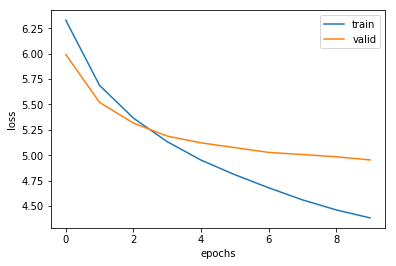

In [16]:
plot_losses()
evaluate(learner)

In [17]:
learner = run_Learner(seq_len=seq_len)
learner.fit(LRs[0],1,wds=weight_decay,use_clr=(30,10),cycle_len=10)

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      6.333954   6.00686    0.180506  
    1      5.675673   5.509767   0.212547                   
    2      5.355607   5.313527   0.222089                   
    3      5.123624   5.192826   0.231092                   
    4      4.942518   5.11351    0.234036                   
    5      4.795388   5.065096   0.236877                   
    6      4.669644   5.023178   0.238411                   
    7      4.551952   5.00889    0.238979                   
    8      4.456935   4.960805   0.244243                   
    9      4.421259   4.914597   0.248442                   


[array([4.9146]), 0.24844215029761904]

100%|██████████| 42/42 [00:02<00:00, 17.56it/s]


(4.867274111793154, 129.96616037895632)

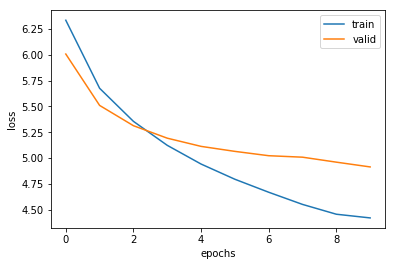

In [18]:
plot_losses()
evaluate(learner)

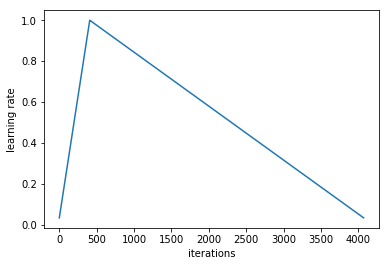

In [20]:
learner.sched.plot_lr()

In [21]:
learner = run_Learner(seq_len=seq_len)
learner.fit(LRs[1],1,wds=weight_decay,use_clr=(30,10),cycle_len=10)

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      6.125131   5.83578    0.192257  
    1      5.559796   5.465888   0.210226                   
    2      5.269918   5.344796   0.215737                   
    3      5.066973   5.283279   0.218504                   
    4      4.900964   5.239211   0.222187                   
    5      4.754005   5.201478   0.226218                   
    6      4.619309   5.160716   0.227595                   
    7      4.478324   5.149925   0.22939                    
    8      4.35283    5.106415   0.236347                   
    9      4.263314   5.038423   0.242001                   


[array([5.03842]), 0.24200148809523808]

100%|██████████| 42/42 [00:02<00:00, 17.42it/s]


(4.9980085100446425, 148.11788989739634)

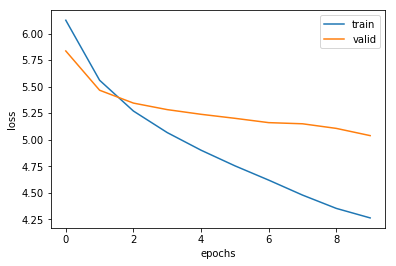

In [22]:
plot_losses()
evaluate(learner)

In [23]:
learner = run_Learner(seq_len=seq_len)
learner.fit(LRs[0],1,wds=weight_decay,use_clr_beta=(30,10,0.95,0.85),cycle_len=10)

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      7.19775    6.80388    0.099214  
    1      6.28775    6.054842   0.178776                   
    2      5.893586   5.746012   0.196503                   
    3      5.631492   5.557099   0.200144                   
    4      5.411292   5.37977    0.2125                     
    5      5.223142   5.270795   0.22021                    
    6      5.066989   5.212254   0.22207                    
    7      4.930644   5.113859   0.233157                   
    8      4.824086   5.042466   0.236142                   
    9      4.798607   4.982007   0.242276                   


[array([4.98201]), 0.24227585643529892]

100%|██████████| 42/42 [00:02<00:00, 17.34it/s]


(4.942213076636905, 140.07991436342206)

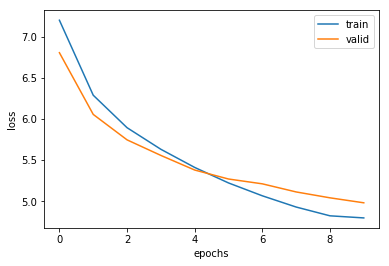

In [24]:
plot_losses()
evaluate(learner)

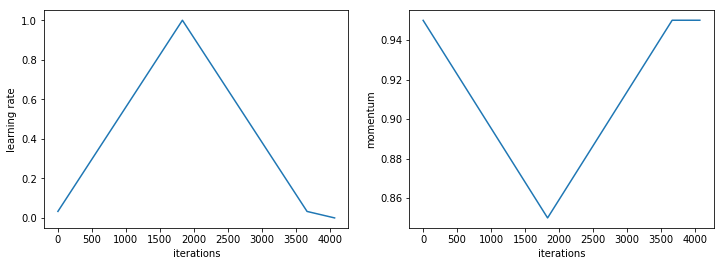

In [26]:
learner.sched.plot_lr()

In [27]:
learner = run_Learner(seq_len=seq_len)
learner.fit(LRs[0],1,wds=weight_decay,use_clr_beta=(30,10,0.95,0.85),cycle_len=30)

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      7.441272   7.011815   0.067592  
    1      6.520145   6.261334   0.158729                   
    2      6.161176   5.950427   0.184984                   
    3      5.926971   5.763923   0.196536                   
    4      5.723109   5.616664   0.200442                   
    5      5.54561    5.517732   0.204841                   
    6      5.379741   5.414099   0.211021                   
    7      5.241334   5.338272   0.214881                   
    8      5.123681   5.281224   0.217313                   
    9      5.025998   5.25062    0.216699                   
    10     4.932217   5.245778   0.217987                   
    11     4.84554    5.146923   0.224493                   
    12     4.780514   5.113668   0.230083                   
    13     4.700227   5.106587   0.226046                   
    14     4.616388   5.083176   0.22945                    
    15     4.543174   5.082248   0.229139

[array([4.9688]), 0.2489164819320043]

100%|██████████| 42/42 [00:02<00:00, 17.81it/s]


(4.875656273251488, 131.06013625530724)

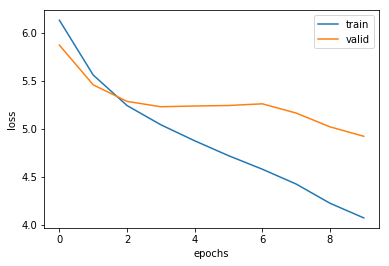

In [15]:
plot_losses()
evaluate(learner)

- max LR test
- one cycle 

In [11]:
weight_decay = 1e-6
seq_len=80
LRs = [10,20,30]

In [12]:
learner = run_Learner(seq_len=seq_len,clip=0.1)
learner.fit(LRs[1],1,wds=weight_decay,use_clr_beta=(30,10,0.95,0.85),cycle_len=10)

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      6.12759    5.868765   0.190025  
    1      5.558342   5.456683   0.207831                   
    2      5.241665   5.28488    0.213802                   
    3      5.041927   5.229353   0.217494                   
    4      4.875762   5.236967   0.21669                    
    5      4.721348   5.242179   0.21895                    
    6      4.580662   5.259791   0.217132                   
    7      4.426739   5.163807   0.223879                   
    8      4.227357   5.020737   0.241797                   
    9      4.074882   4.922534   0.251363                   


[array([4.92253]), 0.2513625369895072]

100%|██████████| 42/42 [00:02<00:00, 17.82it/s]


(4.875656273251488, 131.06013625530724)

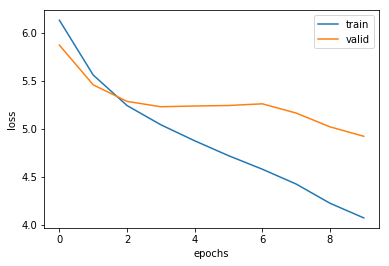

In [16]:
plot_losses()
evaluate(learner)

In [17]:
learner = run_Learner(seq_len=seq_len,clip=0.1)
learner.fit(LRs[1],1,wds=weight_decay,use_clr_beta=(10,10,0.95,0.85),cycle_len=10)

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      6.018736   5.790537   0.19308   
    1      5.510694   5.441755   0.210189                   
    2      5.221892   5.294127   0.215546                   
    3      5.037627   5.275179   0.207654                   
    4      4.887517   5.23476    0.213607                   
    5      4.751507   5.232373   0.215379                   
    6      4.633618   5.237305   0.222084                   
    7      4.506244   5.203057   0.221819                   
    8      4.34219    5.114557   0.23218                    
    9      4.14139    4.96112    0.248684                   


[array([4.96112]), 0.2486839663414728]

100%|██████████| 42/42 [00:02<00:00, 17.22it/s]


(4.91213146391369, 135.92883325889625)

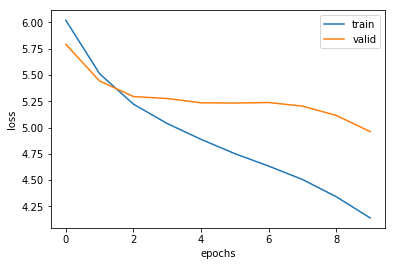

In [18]:
plot_losses()
evaluate(learner)

## One cycle training

Using the TrainingPhase API

In [7]:
def one_cycle(steps,lr,div,mom_max,mom_min,wd):
    return [TrainingPhase(epochs=steps[0],opt_fn=optim.SGD,lr=(lr/div,lr),lr_decay=DecayType.LINEAR,
                          momentum=(mom_max,mom_min),momentum_decay=DecayType.LINEAR,wds=wd),
            TrainingPhase(epochs=steps[1],opt_fn=optim.SGD,lr=(lr,lr/div),lr_decay=DecayType.LINEAR,
                          momentum=(mom_min,mom_max),momentum_decay=DecayType.LINEAR,wds=wd),
            TrainingPhase(epochs=steps[2],opt_fn=optim.SGD,lr=(lr/div,lr/(div*100)),lr_decay=DecayType.LINEAR,
                          momentum=mom_max,wds=wd)]

In [23]:
LR = 75
div = 100
weight_decay = 1e-3

In [24]:
torch.cuda.empty_cache()

In [25]:
learner = run_Learner()
learner.fit_opt_sched(one_cycle([10,10,10], LR, div, 0.95, 0.85, weight_decay))

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      7.905938   7.736914   0.058078  
    1      7.90516    7.728051   0.058078                   
    2      7.906375   7.74283    0.0463                     
    3      nan        nan        0.0                        
    4      nan        nan        0.0                       
    5      nan        nan        0.0                       
    6      nan        nan        0.0                       
    7      nan        nan        0.0                       
    8      nan        nan        0.0                       
    9      nan        nan        0.0                       
    10     nan        nan        0.0                       
    11     nan        nan        0.0                       
    12     nan        nan        0.0                       
    13     nan        nan        0.0                       
    14     nan        nan        0.0                       
    15     nan        nan        0.0                

[array([nan]), 0.0]

nan loss values:
- learning rate might be too high
- might need to clip gradients

In [16]:
%debug

> <ipython-input-12-0735148e4757>(3)tcn_cross_entropy()
      1 def tcn_cross_entropy(output,target):
      2     #reshape: (batch_size,seq_len,vocab_size)
----> 3     output = output.view(-1,seq_len,vocab_size)
      4     #exclude effective history &  reshape: (samples,vocab_size) where samples = batch_size*seq_len
      5     final_output = output[:,eff_history:].contiguous().view(-1,vocab_size)

ipdb> output.shape
torch.Size([6336, 33279])
ipdb> eff_history
40
ipdb> 6400-6336
64
ipdb> q


In [28]:
learner = run_Learner(clip=0.1)
learner.fit_opt_sched(one_cycle([10,10,10], LR, div, 0.95, 0.85, weight_decay))

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      7.906105   7.736877   0.058078  
    1      7.90516    7.728051   0.058078                   
    2      7.906375   7.742831   0.0463                     
    3      nan        nan        0.0                        


KeyboardInterrupt: 

In [31]:
torch.cuda.empty_cache()

Decrease weight decay...1e-3 was too high. High wd leads to zeroing out of weights, thus preventing the model from learning.  

In [33]:
LR = 10
div = 100
weight_decay = 1e-5

learner = run_Learner()
learner.fit_opt_sched(one_cycle([10,10,10], LR, div, 0.95, 0.85, weight_decay))

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      6.545917   6.129265   0.173901  
    1      5.804074   5.586499   0.208408                   
    2      5.46284    5.404803   0.209474                   
    3      5.272829   5.314346   0.206995                   
    4      5.128228   5.280438   0.216856                   
    5      5.054963   5.245326   0.214732                   
    6      5.074679   5.243064   0.216024                   
    7      5.086622   5.467137   0.19905                    
    8      5.119008   5.414567   0.199193                   
    9      5.108722   5.397384   0.195346                   
    10     4.96195    5.277063   0.204332                   
    11     4.817575   5.250081   0.21305                    
    12     4.730791   5.191692   0.216442                   
    13     4.669134   5.247943   0.207256                   
    14     4.589726   5.141289   0.22564                    
    15     4.508548   5.145208   0.223093

[array([4.86517]), 0.25558563453309674]

In [40]:
validate(learner.model,learner.data.val_dl)

100%|██████████| 34/34 [00:02<00:00, 14.26it/s]


(4.820840772897253, 124.06936109604268)

the state of the art perplexity with this dataset is 52 with cache pointer and 68 without.

In [38]:
%debug

> <ipython-input-34-227afda86893>(11)validate()
      9     for data, targets in tqdm(source):
     10         output = model(V(data))  #run inference on data.
---> 11         output = output.view(-1,seq_len,vocab_size)  #delete this later, reshape into batch_size x seq_len x vocab_size
     12         final_output = output[:,eff_history:].contiguous().view(-1,vocab_size) #resize to  samples x vocab_size
     13         target = targets.contiguous().view(-1,seq_len) #delete this later

ipdb> data.shape
torch.Size([64, 99])
ipdb> targets.shape
torch.Size([6336])
ipdb> 64*99
6336
ipdb> output.size(1)
33279
ipdb> output.shape
torch.Size([6336, 33279])
ipdb> data.size(1)
99
ipdb> d  = output.view(-1,data.size(1),vocab_size)
*** Newest frame
ipdb> d.shape
*** Newest frame
ipdb> d
*** Newest frame
ipdb> help

Documented commands (type help <topic>):
EOF    cl         disable  interact  next    psource  rv         unt   
a      clear      display  j         p       q        s          until 


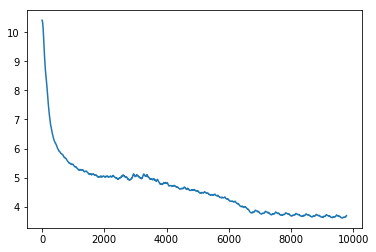

In [41]:
trn_loss = learner.sched.losses
val_loss = learner.sched.val_losses
x_lrs = learner.sched.lrs

plt.plot(trn_loss)

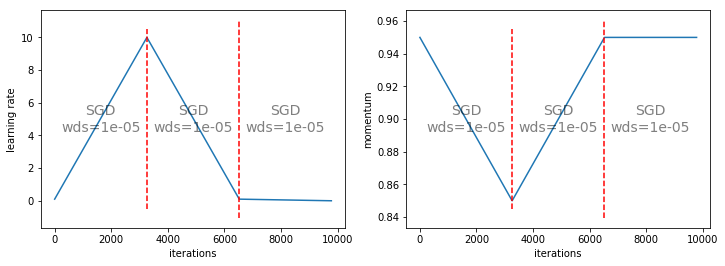

In [42]:
learner.sched.plot_lr()

In [43]:
torch.cuda.empty_cache()

Repeat for longer ...

In [44]:
learner = run_Learner()
learner.fit_opt_sched(one_cycle([50,50,50], LR, div, 0.95, 0.85, weight_decay))

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      7.04313    6.555551   0.123975  
    1      6.139633   5.89528    0.192313                   
    2      5.763676   5.605031   0.204647                   
    3      5.485101   5.399957   0.215101                   
    4      5.25989    5.256676   0.219303                   
    5      5.109703   5.177692   0.222561                   
    6      4.96255    5.175408   0.217867                   
    7      4.876383   5.129979   0.221311                   
    8      4.77421    5.121489   0.221752                   
    9      4.701308   5.101715   0.225778                   
    10     4.657698   5.121968   0.221854                   
    11     4.608108   5.172194   0.223669                   
    12     4.538594   5.147306   0.224322                   
    13     4.52675    5.130188   0.227231                   
    14     4.499355   5.186031   0.213556                   
    15     4.495444   5.210529   0.217346

[array([5.62544]), 0.22799428070292754]

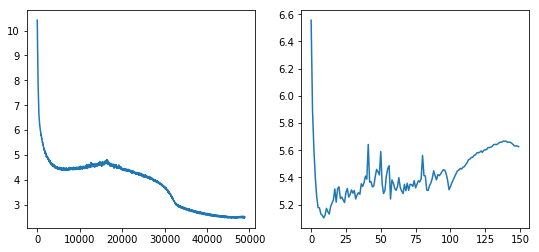

In [52]:
trn_loss = learner.sched.losses
val_loss = learner.sched.val_losses

fig,ax = plt.subplots(1,2,figsize=(9,4))
ax[0].plot(trn_loss)
ax[1].plot(val_loss)

In [47]:
validate(learner.model,learner.data.val_dl)

100%|██████████| 34/34 [00:02<00:00, 14.16it/s]


(5.592211638670917, 268.32840944050133)

In [48]:
torch.cuda.empty_cache()

## LR_Finder via trainingphase API

In [55]:
phases = [TrainingPhase(epochs=0.5,opt_fn=optim.SGD,lr=(1e-2,100),lr_decay=DecayType.EXPONENTIAL,\
                          momentum=(0.95,0.85),wds=1e-5,momentum_decay=DecayType.EXPONENTIAL)]

learner = run_Learner()
learner.fit_opt_sched(phases, stop_div=True)

Loading model...
Tied weights
Done loading.


 44%|████▍     | 145/326 [00:33<00:42,  4.30it/s, loss=59]  

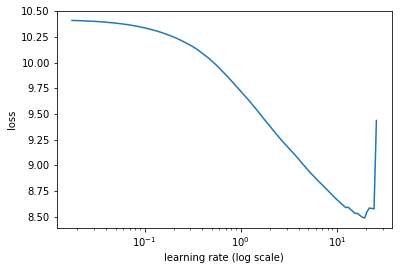

In [62]:
learner.sched.plot()

In [66]:
LR = 12
div = 10
weight_decay = 1e-5

learner = run_Learner()
learner.fit_opt_sched(one_cycle([10,10,20], LR, div, 0.95, 0.85, weight_decay))

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      6.313512   5.947351   0.186981  
    1      5.671241   5.507148   0.212044                   
    2      5.394166   5.35979    0.213271                   
    3      5.269573   5.382724   0.205533                   
    4      5.164143   5.281037   0.215923                   
    5      5.137233   5.346222   0.206039                   
    6      5.261135   5.613829   0.176205                   
    7      5.297856   5.753668   0.189904                   
    8      5.528709   5.928233   0.175134                   
    9      5.809688   6.093508   0.145722                   
    10     5.788181   5.684509   0.177869                   
    11     5.69093    5.702935   0.179047                   
    12     5.354663   5.545759   0.185933                   
    13     5.502718   5.524026   0.192411                   
    14     5.241663   5.401437   0.200454                   
    15     5.010999   5.292183   0.208228

[array([5.05509]), 0.24771139595438452]

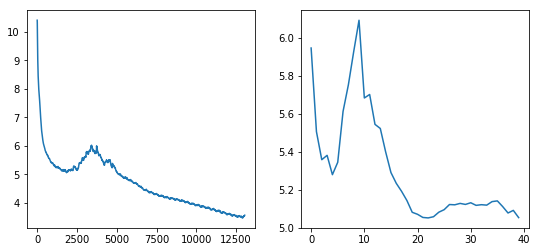

In [68]:
trn_loss = learner.sched.losses
val_loss = learner.sched.val_losses

fig,ax = plt.subplots(1,2,figsize=(9,4))
ax[0].plot(trn_loss)
ax[1].plot(val_loss)

In [71]:
validate(learner)

100%|██████████| 34/34 [00:02<00:00, 14.28it/s]


(5.009816392839627, 149.87721509272478)

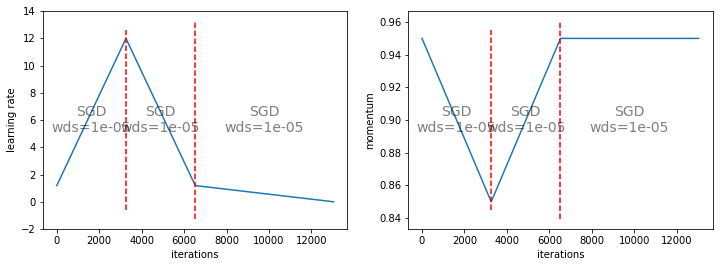

In [73]:
learner.sched.plot_lr()

## CLR

In [75]:
learner = run_Learner()
learner.fit(10,n_cycle=1,wds=1e-5,cycle_len=10,use_clr_beta=(10,15,0.95,0.85))

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      6.282106   5.906568   0.190415  
    1      5.664691   5.503293   0.210181                   
    2      5.451507   5.37402    0.20899                    
    3      5.540535   5.640251   0.171846                   
    4      5.27618    5.360459   0.198665                   
    5      5.044233   5.228377   0.216198                   
    6      4.901237   5.193992   0.220114                   
    7      4.752105   5.108969   0.230678                   
    8      4.537758   4.987163   0.238176                   
    9      4.3629     4.869938   0.250192                   


[array([4.86994]), 0.2501923157011761]

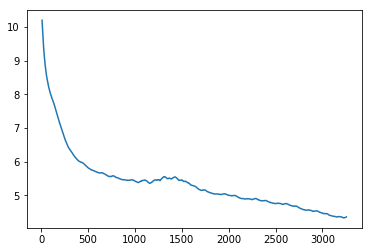

In [77]:
learner.sched.plot_loss()

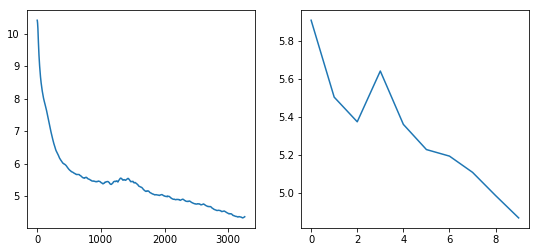

In [78]:
trn_loss = learner.sched.losses
val_loss = learner.sched.val_losses

fig,ax = plt.subplots(1,2,figsize=(9,4))
ax[0].plot(trn_loss)
ax[1].plot(val_loss)

In [80]:
evaluate(learner)

100%|██████████| 34/34 [00:02<00:00, 14.18it/s]


(4.831676354064492, 125.42103458752815)

In [81]:
#learner = run_Learner()
learner.fit(10,n_cycle=1,wds=1e-5,cycle_len=15,use_clr_beta=(20,10,0.95,0.85))

epoch      trn_loss   val_loss   accuracy                   
    0      4.533465   5.060575   0.229427  
    1      4.587036   5.128833   0.222555                   
    2      4.655702   5.157099   0.217553                   
    3      4.745754   5.307585   0.203106                   
    4      4.844744   5.384119   0.208608                   
    5      4.952305   5.387117   0.192082                   
    6      4.932276   5.349697   0.207018                   
    7      4.785442   5.243959   0.212756                   
    8      4.663307   5.172066   0.217784                   
 15%|█▍        | 48/326 [00:11<01:06,  4.17it/s, loss=4.63]

KeyboardInterrupt: 

In [82]:
torch.cuda.empty_cache()

In [6]:
learner = run_Learner()
learner.fit(10,n_cycle=1,wds=1e-5,cycle_len=25,use_clr_beta=(10,15,0.95,0.85))

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      6.385679   6.002914   0.179419  
    1      5.697799   5.510032   0.210636                   
    2      5.385606   5.380729   0.213844                   
    3      5.228337   5.287188   0.213818                   
    4      5.124136   5.295525   0.193911                   
    5      5.033912   5.258563   0.215771                   
    6      5.023862   5.285122   0.203666                   
    7      5.024786   5.484139   0.195296                   
    8      5.036703   5.326705   0.207988                   
    9      5.075178   5.376814   0.191526                   
    10     5.010448   5.320423   0.199065                   
    11     4.92355    5.257944   0.210475                   
    12     4.846968   5.28271    0.210562                   
    13     4.760304   5.269388   0.215485                   
    14     4.678734   5.220424   0.215766                   
    15     4.618301   5.208169   0.216456

[array([4.89686]), 0.25361839944825454]

In [7]:
learner = run_Learner()
learner.fit(8,n_cycle=1,wds=1e-5,cycle_len=45,use_clr_beta=(10,12.5,0.95,0.85))

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      6.482727   6.062377   0.178895  
    1      5.76023    5.554286   0.209221                   
    2      5.434996   5.342528   0.217749                   
    3      5.210472   5.242345   0.219839                   
    4      5.061752   5.195363   0.219514                   
    5      4.942687   5.148289   0.223126                   
    6      4.832778   5.181764   0.208705                   
    7      4.791807   5.131162   0.224114                   
    8      4.734583   5.140023   0.216445                   
    9      4.715219   5.173533   0.21525                    
    10     4.679933   5.214721   0.215698                   
    11     4.670099   5.277686   0.208564                   
    12     4.643314   5.295246   0.202241                   
    13     4.618417   5.315922   0.203474                   
    14     4.621656   5.183349   0.221175                   
    15     4.621367   5.200811   0.218441

[array([5.07301]), 0.246591836652335]

In [8]:
learner = run_Learner()
learner.fit(10,n_cycle=1,wds=1e-5,cycle_len=45,use_clr_beta=(10,30,0.95,0.85))

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      6.412755   6.006036   0.184067  
    1      5.710298   5.522378   0.20997                    
    2      5.398122   5.352085   0.217771                   
    3      5.202064   5.263799   0.218174                   
    4      5.056519   5.246243   0.210332                   
    5      4.983046   5.228439   0.219089                   
    6      4.929756   5.235625   0.210059                   
    7      4.900167   5.298151   0.208636                   
    8      4.867422   5.366519   0.19107                    
    9      4.85949    5.409751   0.184038                   
    10     4.883113   5.291785   0.203042                   
    11     4.872852   5.295469   0.209354                   
    12     4.899703   5.35462    0.204168                   
    13     4.919213   5.383281   0.209018                   
    14     4.91455    5.418222   0.197451                   
    15     4.945063   5.540902   0.184741

[array([5.13692]), 0.24521896330749288]

Notes/To-do: 

- ~~Use trainingphase API for learning rate finder with cyclic momentum~~
- ~~For one-cycle, the 'div' is actually supposed to be 10 or 20 (according to Leslie Smith)~~
- increase nlevels to 5

In [35]:
learner.model

Sequential(
  (0): TCN_Encoder(
    (encoder): Embedding(33279, 400)
    (dropoute): Dropout(p=0.1, inplace)
    (tcn_module): TemporalConvModule(
      (tcn_module): Sequential(
        (0): BasicTempConvBlock(
          (conv1): Conv1d(400, 1000, kernel_size=(3,), stride=(1,), padding=(2,), bias=False)
          (chop1): Chop1d(
          )
          (relu1): ReLU(inplace)
          (dropout1): Dropout(p=0.2, inplace)
          (conv2): Conv1d(1000, 1000, kernel_size=(3,), stride=(1,), padding=(2,), bias=False)
          (chop2): Chop1d(
          )
          (relu2): ReLU(inplace)
          (dropout2): Dropout(p=0.2, inplace)
          (downsample): Conv1d(400, 1000, kernel_size=(1,), stride=(1,), bias=False)
          (relu3): ReLU(inplace)
        )
        (1): BasicTempConvBlock(
          (conv1): Conv1d(1000, 1000, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,), bias=False)
          (chop1): Chop1d(
          )
          (relu1): ReLU(inplace)
          (dropout1)

## Go deeper

Loading model...
Tied weights
Running LR_find...


 69%|██████▊   | 224/326 [01:05<00:29,  3.42it/s, loss=5.45e+03]

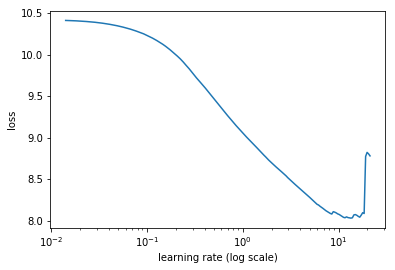

In [11]:
learner_lr = run_LR_find(bs=64,nlevels=5,weight_decay=1e-5)

Loading model...
Tied weights
Running LR_find...


 73%|███████▎  | 152/208 [01:07<00:24,  2.25it/s, loss=33.9]

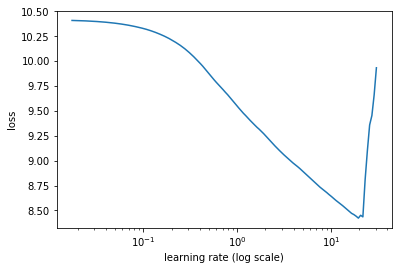

In [12]:
learner_lr = run_LR_find(bs=100,nlevels=5,weight_decay=1e-5)

Loading model...
Tied weights
Running LR_find...


 74%|███████▎  | 153/208 [01:09<00:24,  2.22it/s, loss=37.8]

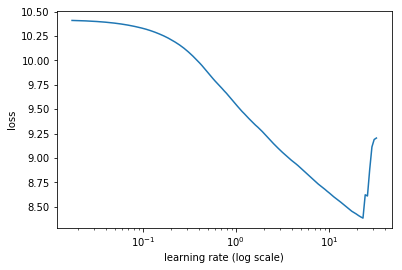

In [15]:
learner_lr = run_LR_find(bs=100,nlevels=5,weight_decay=1e-6)

Loading model...
Tied weights
Running LR_find...


 67%|██████▋   | 219/326 [01:06<00:32,  3.30it/s, loss=50.9]

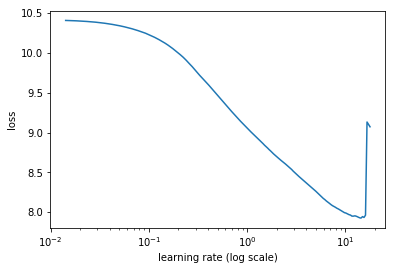

In [7]:
learner_lr = run_LR_find(bs=64,nlevels=5,weight_decay=0)

Loading model...
Tied weights
Running LR_find...


 68%|██████▊   | 223/326 [01:06<00:30,  3.34it/s, loss=358] 

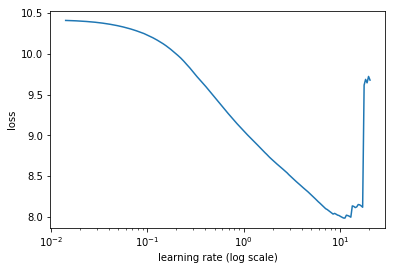

In [8]:
learner_lr = run_LR_find(bs=64,nlevels=5,weight_decay=1e-7)

In [16]:
learner = run_Learner(nlevels=5) 
learner.fit(15,n_cycle=1,wds=1e-5,cycle_len=20,use_clr_beta=(10,15,0.95,0.85))

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      6.242944   5.884287   0.193507  
    1      5.655283   5.516046   0.207412                   
    2      5.481086   5.463041   0.200061                   
    3      5.542005   5.654607   0.168885                   
    4      5.835651   5.909654   0.169227                   
    5      6.124762   6.175617   0.139167                   
    6      6.369925   6.157501   0.127954                   
    7      8.999298   7.007907   0.058078                   
    8      7.14826    6.949138   0.058078                   
 10%|█         | 34/326 [00:09<01:25,  3.41it/s, loss=7.14]

KeyboardInterrupt: 

In [9]:
learner = run_Learner(nlevels=5) 
learner.fit(9,n_cycle=1,wds=1e-7,cycle_len=20,use_clr_beta=(10,15,0.95,0.85))

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      6.367211   5.965176   0.186842  
    1      5.684065   5.512205   0.205572                   
    2      5.348336   5.357238   0.212497                   
    3      5.133076   5.239136   0.218607                   
    4      5.005074   5.260319   0.205133                   
    5      4.939109   5.292685   0.198265                   
    6      4.827105   5.256786   0.21509                    
    7      4.757842   5.260335   0.211682                   
    8      4.680918   5.263745   0.213104                   
    9      4.592985   5.314722   0.207678                   
    10     4.508237   5.299308   0.220442                   
    11     4.430381   5.263158   0.219389                   
    12     4.3431     5.279283   0.222813                   
    13     4.282778   5.315964   0.218874                   
    14     4.22       5.321909   0.221603                   
    15     4.142588   5.289595   0.225681

[array([5.15237]), 0.2472967242493349]

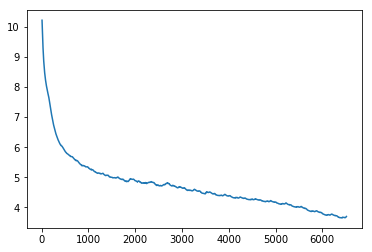

In [12]:
learner.sched.plot_loss()

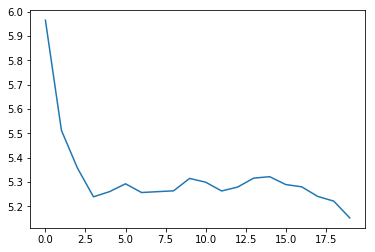

In [14]:
plt.plot(learner.sched.val_losses)

looks promising...how do I leverage the dip towards the end?

In [18]:
learner.lr_find(wds=1e-5)

epoch      trn_loss   val_loss   accuracy                   
    0      3.889285   5.707477   0.181892  


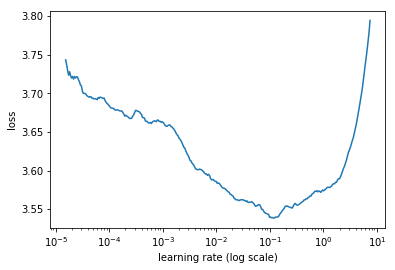

In [19]:
learner.sched.plot()

In [20]:
#learner = run_Learner(nlevels=5) 
learner.fit(0.08,n_cycle=1,wds=1e-7,cycle_len=20,use_clr_beta=(10,40,0.95,0.85))

epoch      trn_loss   val_loss   accuracy                   
    0      3.651357   5.156325   0.247697  
    1      3.64017    5.158152   0.247766                   
    2      3.631918   5.162742   0.247904                   
    3      3.621065   5.167571   0.247949                   
    4      3.614086   5.171265   0.247849                   
    5      3.604929   5.176866   0.247753                   
    6      3.598304   5.178389   0.247532                   
    7      3.59229    5.182629   0.247523                   
    8      3.588336   5.184735   0.247532                   
    9      3.58589    5.187652   0.247398                   
    10     3.579605   5.189312   0.247398                   
    11     3.573583   5.191964   0.247131                   
    12     3.570018   5.192207   0.247274                   
    13     3.567482   5.193115   0.247219                   
    14     3.563657   5.194072   0.247145                   
    15     3.562242   5.193734   0.247352

[array([5.19328]), 0.24760964249863343]

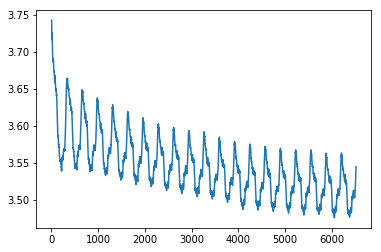

In [22]:
learner.sched.plot_loss()

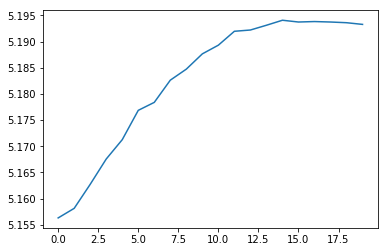

In [23]:
plt.plot(learner.sched.val_losses)

overfitting - val_loss increasing. 

## One-cycle revisted

The below worked well previosuly, just extending the number of epochs of the last phase.

In [28]:
LR = 10
div = 100
weight_decay = 1e-5

learner = run_Learner()
learner.fit_opt_sched(one_cycle([10,10,25], LR, div, 0.95, 0.85, weight_decay))

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      6.559397   6.130543   0.17659   
    1      5.79387    5.593875   0.204454                   
    2      5.457845   5.463279   0.201355                   
    3      5.255792   5.316766   0.214548                   
    4      5.144226   5.270164   0.215818                   
    5      5.075741   5.277356   0.198981                   
    6      5.070029   5.348652   0.207239                   
    7      5.059965   5.540365   0.179714                   
    8      5.046287   5.299532   0.211233                   
    9      5.134554   5.518734   0.204866                   
    10     4.953116   5.253908   0.215507                   
    11     4.821995   5.286029   0.205956                   
    12     4.747922   5.251505   0.212581                   
    13     4.674144   5.193941   0.218824                   
    14     4.58613    5.174982   0.219593                   
    15     4.507577   5.162856   0.218464

[array([4.92216]), 0.2542791883735096]

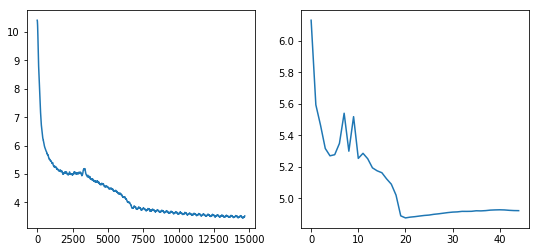

In [29]:
trn_loss = learner.sched.losses
val_loss = learner.sched.val_losses

fig,ax = plt.subplots(1,2,figsize=(9,4))
ax[0].plot(trn_loss)
ax[1].plot(val_loss)

5 level

In [30]:
LR = 9
div = 100
weight_decay = 1e-7

learner = run_Learner(nlevels=5) 
learner.fit_opt_sched(one_cycle([10,10,25], LR, div, 0.95, 0.85, weight_decay))

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      6.56238    6.131367   0.168376  
    1      5.794823   5.576122   0.208275                   
    2      5.441308   5.362296   0.216898                   
    3      5.198689   5.240965   0.219227                   
    4      5.034719   5.248716   0.199621                   
    5      4.935775   5.186522   0.218984                   
    6      4.811628   5.26979    0.214681                   
    7      4.793082   5.252996   0.215068                   
    8      4.808502   5.376125   0.208277                   
    9      4.7232     5.264646   0.213841                   
    10     4.580196   5.238904   0.221098                   
    11     4.508974   5.336912   0.216842                   
    12     4.401687   5.305021   0.220385                   
    13     4.322845   5.295829   0.218832                   
    14     4.256002   5.339312   0.215196                   
    15     4.174264   5.359115   0.222325

[array([5.2542]), 0.24704443268916187]

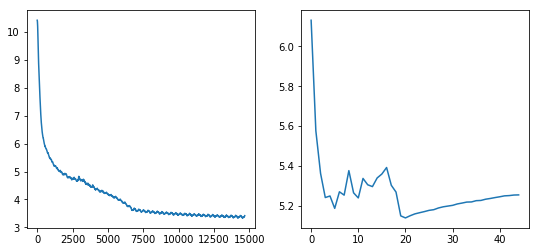

In [31]:
trn_loss2 = learner.sched.losses
val_loss2 = learner.sched.val_losses

fig,ax = plt.subplots(1,2,figsize=(9,4))
ax[0].plot(trn_loss2)
ax[1].plot(val_loss2)

In [32]:
def plot_losses():
    trn_loss = learner.sched.losses
    val_loss = learner.sched.val_losses

    fig,ax = plt.subplots(1,2,figsize=(9,4))
    ax[0].plot(trn_loss)
    ax[1].plot(val_loss)  

In [33]:
LR = 10
div = 200
weight_decay = 1e-5

learner = run_Learner()
learner.fit_opt_sched(one_cycle([10,20,5], LR, div, 0.95, 0.85, weight_decay))

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      6.592456   6.158781   0.172058  
    1      5.812255   5.609336   0.205433                   
    2      5.467974   5.356171   0.218323                   
    3      5.269163   5.318915   0.214378                   
    4      5.166588   5.262023   0.214562                   
    5      5.054456   5.291473   0.211294                   
    6      5.043594   5.418537   0.185605                   
    7      5.074359   5.375484   0.204513                   
    8      5.04566    5.468983   0.184403                   
    9      5.202064   5.530628   0.175529                   
    10     5.048025   5.401862   0.185333                   
    11     4.95599    5.493291   0.204218                   
    12     4.841056   5.190592   0.216994                   
    13     4.865739   5.416711   0.204434                   
    14     4.745622   5.202655   0.216515                   
    15     4.694742   5.211579   0.216694

[array([4.9397]), 0.25273609161376953]

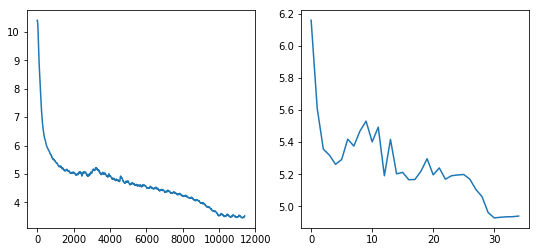

In [35]:
plot_losses()

In [36]:
evaluate(learner)

100%|██████████| 34/34 [00:02<00:00, 14.14it/s]


(4.892565672511035, 133.29512735106493)

Lower the learning rate to the point where the loss is still decreasing (at the slope). 

In [37]:
LR = 4
div = 10
weight_decay = 1e-5

learner = run_Learner()
learner.fit_opt_sched(one_cycle([10,10,4], LR, div, 0.95, 0.85, weight_decay))

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      6.617856   6.175746   0.170486  
    1      5.849575   5.635247   0.203093                   
    2      5.52024    5.392682   0.218677                   
    3      5.282583   5.282281   0.219339                   
    4      5.102587   5.169916   0.227428                   
    5      4.960951   5.20389    0.218562                   
    6      4.85092    5.281762   0.21374                    
    7      4.784999   5.18626    0.213335                   
    8      4.690964   5.057086   0.228017                   
    9      4.637019   5.168564   0.202067                   
    10     4.566416   5.168856   0.219375                   
    11     4.480388   5.107961   0.231855                   
    12     4.386121   5.078376   0.221188                   
    13     4.317302   5.053467   0.231342                   
    14     4.260501   5.045512   0.235915                   
    15     4.192823   5.132738   0.229322

[array([4.88719]), 0.25615915568435893]

100%|██████████| 34/34 [00:02<00:00, 14.08it/s]


(4.838459607957332, 126.27468931377825)

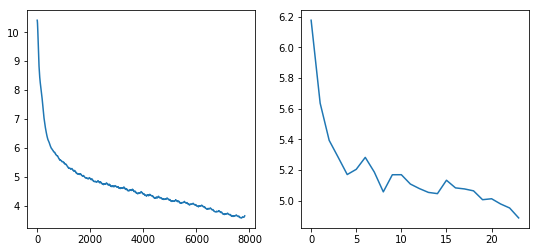

In [38]:
plot_losses()
evaluate(learner)

In [39]:
LR = 3.5
div = 10
weight_decay = 1e-5

learner = run_Learner()
learner.fit_opt_sched(one_cycle([10,10,4], LR, div, 0.95, 0.85, weight_decay))

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      6.567814   6.176236   0.17187   
    1      5.879777   5.662396   0.20272                    
    2      5.546107   5.432283   0.212646                   
    3      5.29508    5.280704   0.218157                   
    4      5.124914   5.224494   0.215619                   
    5      4.97111    5.099424   0.230104                   
    6      4.858146   5.077163   0.227999                   
    7      4.7838     5.114409   0.221212                   
    8      4.690418   5.149709   0.20259                    
    9      4.639382   5.177448   0.226045                   
    10     4.55927    5.073342   0.225558                   
    11     4.456858   5.027394   0.234141                   
    12     4.379302   5.068857   0.231575                   
    13     4.321902   5.003554   0.234342                   
    14     4.240838   5.086789   0.224887                   
    15     4.182813   5.067464   0.227743

[array([4.87201]), 0.2574194152565563]

100%|██████████| 34/34 [00:02<00:00, 14.00it/s]


(4.8222091098577735, 124.23924599188258)

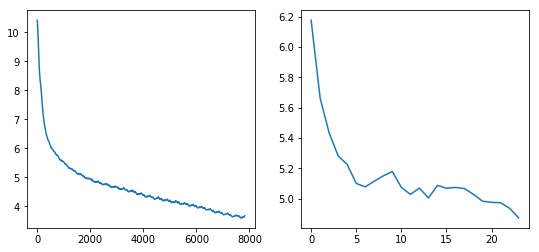

In [40]:
plot_losses()
evaluate(learner)

In [41]:
LR = 3.5
div = 10
weight_decay = 1e-5

learner = run_Learner()
learner.fit_opt_sched(one_cycle([30,30,10], LR, div, 0.95, 0.85, weight_decay))

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      6.615098   6.24787    0.163025  
    1      5.961235   5.754725   0.197719                   
    2      5.635628   5.49228    0.21328                    
    3      5.393796   5.320231   0.220451                   
    4      5.203596   5.221201   0.221954                   
    5      5.042688   5.176178   0.221333                   
    6      4.917092   5.106845   0.22672                    
    7      4.818713   5.092485   0.222754                   
    8      4.732472   5.079105   0.22627                    
    9      4.665491   5.117443   0.207047                   
    10     4.563314   4.992613   0.234348                   
    11     4.488648   5.013819   0.231843                   
    12     4.437211   5.044595   0.22536                    
    13     4.387605   5.082755   0.213707                   
    14     4.324628   5.057594   0.219306                   
    15     4.297456   5.031359   0.231461

[array([5.22789]), 0.243914094479645]

100%|██████████| 34/34 [00:02<00:00, 14.25it/s]


(5.176233850079696, 177.01488942476033)

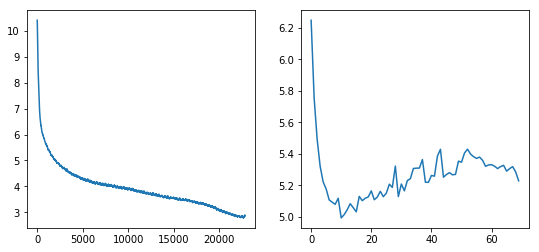

In [42]:
plot_losses()
evaluate(learner)

Seems like the longer the cycles the worse the validation peformance. From the val_loss curve (right) the model starts overfitting after 15 epochs. 

In [9]:
def plot_losses():
    epochs = len(learner.sched.val_losses)
    its = len(learner.sched.losses) #iterations
    ipe = its//epochs #iterations per epoch
    #grab the loss at the end of each epoch.
    trn_losses = [learner.sched.losses[i] for i in range(ipe-1,its,ipe)]

    fig,ax = plt.subplots(1,1,figsize=(6,4))
    ax.plot(trn_losses,label='train')
    ax.plot(learner.sched.val_losses,label='valid')
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    ax.legend()
#plot_losses()

In [10]:
LR = 3.5
div = 10
weight_decay = 1e-5

learner = run_Learner()
learner.fit_opt_sched(one_cycle([10,10,10], LR, div, 0.95, 0.85, weight_decay))

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      6.554618   6.166669   0.171433  
    1      5.874474   5.664498   0.203635                   
    2      5.548388   5.440457   0.211979                   
    3      5.29914    5.276736   0.217927                   
    4      5.123199   5.198437   0.22022                    
    5      4.972896   5.121089   0.222161                   
    6      4.852219   5.072856   0.230177                   
    7      4.791155   5.157335   0.21596                    
    8      4.709067   5.04757    0.230601                   
    9      4.655062   5.118062   0.213858                   
    10     4.540128   5.017624   0.233855                   
    11     4.453584   5.097703   0.230292                   
    12     4.381521   5.025766   0.231152                   
    13     4.317487   5.064702   0.225833                   
    14     4.252024   5.067599   0.230454                   
    15     4.197961   5.055709   0.232429

[array([4.93197]), 0.25509270105291815]

100%|██████████| 34/34 [00:02<00:00, 14.21it/s]


(4.8792870087972045, 131.53684583016008)

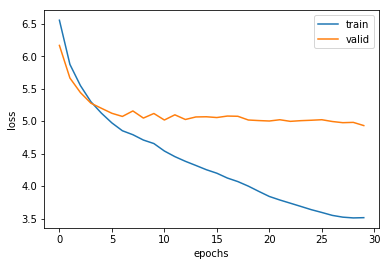

In [12]:
plot_losses()
evaluate(learner)

In [13]:
learner = run_Learner()
learner.fit(3.5,1,wds=weight_decay,use_clr=(10,10),cycle_len=5)

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      6.223297   5.851743   0.189758  
    1      5.632784   5.495313   0.206852                   
    2      5.337102   5.325967   0.221662                   
    3      5.113177   5.223612   0.222951                   
    4      4.907774   5.071178   0.235151                   



[array([5.07118]), 0.23515146883095012]

100%|██████████| 34/34 [00:02<00:00, 14.28it/s]


(5.040070672664296, 154.48093221917557)

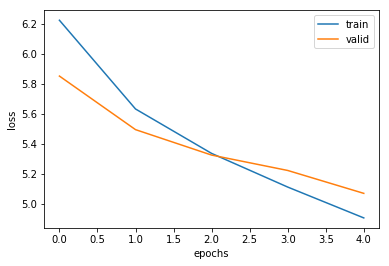

In [14]:
plot_losses()
evaluate(learner)

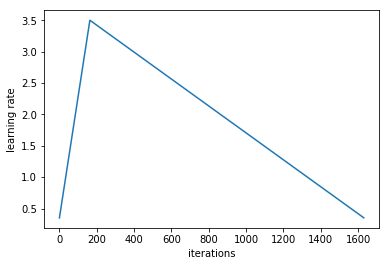

In [15]:
learner.sched.plot_lr()

In [17]:
learner = run_Learner()
learner.fit(3.5,1,wds=weight_decay,use_clr=(10,5),cycle_len=5)

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      6.287024   5.898814   0.193551  
    1      5.62639    5.470975   0.210812                   
    2      5.302413   5.304541   0.222422                   
    3      5.064537   5.18931    0.226712                   
    4      4.853359   5.050177   0.237068                   



[array([5.05018]), 0.23706820125088973]

100%|██████████| 34/34 [00:02<00:00, 14.16it/s]


(5.018847799932565, 151.23694814519502)

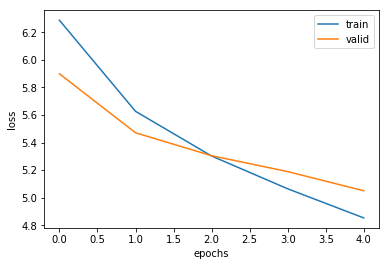

In [18]:
plot_losses()
evaluate(learner)

In [19]:
learner = run_Learner()
learner.fit(3.5,1,wds=weight_decay,use_clr=(10,5),cycle_len=15)

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      6.455583   6.029723   0.182779  
    1      5.735948   5.550471   0.209262                   
    2      5.464234   5.424072   0.211271                   
    3      5.275108   5.377077   0.199478                   
    4      5.115594   5.308942   0.214356                   
    5      5.000917   5.258269   0.218273                   
    6      4.895883   5.241242   0.218805                   
    7      4.783455   5.218402   0.220952                   
    8      4.688557   5.187884   0.220552                   
    9      4.600732   5.167033   0.22485                    
    10     4.500275   5.158182   0.227389                   
    11     4.399424   5.105381   0.232038                   
    12     4.290502   5.064877   0.233785                   
    13     4.173842   5.044239   0.232307                   
    14     4.068336   4.993045   0.241724                   



[array([4.99304]), 0.24172436665086186]

100%|██████████| 34/34 [00:02<00:00, 14.14it/s]


(4.951564607344286, 141.39602019489678)

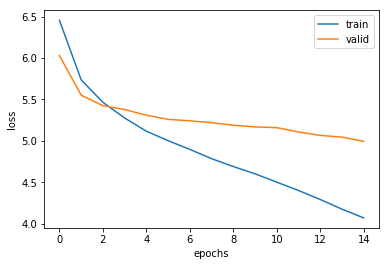

In [21]:
plot_losses()
evaluate(learner)

In [22]:
learner = run_Learner()
learner.fit(3.5,4,wds=weight_decay,use_clr=(10,5),cycle_len=5)

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      6.300611   5.91472    0.191123  
    1      5.638632   5.498852   0.208297                   
    2      5.318295   5.306948   0.222523                   
    3      5.075619   5.207845   0.225145                   
    4      4.864939   5.060093   0.235128                   
    5      5.141199   5.354508   0.205984                   
    6      5.03547    5.257012   0.216818                   
    7      4.842828   5.17352    0.225575                   
    8      4.669913   5.092374   0.228568                   
    9      4.472234   4.964502   0.241049                   
    10     4.811032   5.287552   0.204397                   
    11     4.820826   5.231777   0.216723                   
    12     4.64393    5.166572   0.225014                   
    13     4.458038   5.082921   0.228821                   
    14     4.257172   4.976326   0.242724                   
    15     4.646719   5.259181   0.210016

[array([4.98016]), 0.24153617900960586]

100%|██████████| 34/34 [00:02<00:00, 14.07it/s]


(4.941851187009563, 140.02923006702878)

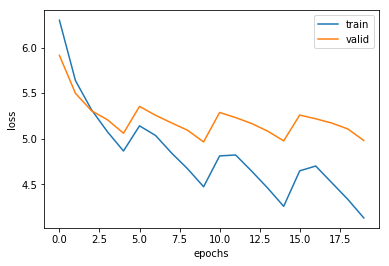

In [23]:
plot_losses()
evaluate(learner)

In [25]:
learner = run_Learner()
learner.fit(3.5,1,wds=weight_decay,use_clr=(10,20),cycle_len=15)

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      6.286522   5.895908   0.191136  
    1      5.65747    5.520351   0.209555                   
    2      5.386011   5.390718   0.212277                   
    3      5.205768   5.311309   0.218272                   
    4      5.086496   5.292931   0.213923                   
    5      4.963822   5.245972   0.21771                    
    6      4.885348   5.2044     0.222142                   
    7      4.776678   5.208141   0.21527                    
    8      4.688687   5.188165   0.220821                   
    9      4.587795   5.135857   0.226981                   
    10     4.501764   5.16555    0.224058                   
    11     4.404705   5.10913    0.225832                   
    12     4.303292   5.077356   0.233216                   
    13     4.199273   5.050137   0.233925                   
    14     4.101035   5.019952   0.239776                   



[array([5.01995]), 0.23977555904318304]

In [26]:
learner = run_Learner()
learner.fit(3.5,1,wds=weight_decay,use_clr=(20,10),cycle_len=15)

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      6.439633   5.988232   0.183087  
    1      5.706822   5.528727   0.209923                   
    2      5.395409   5.38632    0.210906                   
    3      5.201924   5.323881   0.208235                   
    4      5.062125   5.260899   0.217564                   
    5      4.9506     5.238327   0.217242                   
    6      4.842319   5.193313   0.216119                   
    7      4.744311   5.173842   0.2226                     
    8      4.646935   5.166494   0.225052                   
    9      4.558174   5.120712   0.229216                   
    10     4.444084   5.117147   0.227635                   
    11     4.344086   5.07894    0.22957                    
    12     4.237791   5.051548   0.232697                   
    13     4.131257   5.034017   0.236659                   
    14     4.025812   4.971332   0.245881                   



[array([4.97133]), 0.24588123796617284]

In [27]:
learner = run_Learner()
learner.fit(3.5,15,wds=weight_decay)

Loading model...
Tied weights
Done loading.


epoch      trn_loss   val_loss   accuracy                   
    0      6.146538   5.81933    0.18949   
    1      5.645888   5.523825   0.208393                   
    2      5.420688   5.407487   0.212104                   
    3      5.280993   5.355233   0.215361                   
    4      5.180332   5.337239   0.213009                   
    5      5.110849   5.325728   0.207225                   
    6      5.065454   5.297239   0.213476                   
    7      5.006377   5.312373   0.209                      
    8      4.968328   5.305026   0.212603                   
    9      4.944794   5.281194   0.215738                   
    10     4.915825   5.289914   0.211988                   
    11     4.914215   5.350717   0.210168                   
    12     4.876112   5.299491   0.216694                   
    13     4.849488   5.362306   0.210549                   
    14     4.836237   5.310021   0.21248                    



[array([5.31002]), 0.212479528697098]

100%|██████████| 34/34 [00:02<00:00, 14.25it/s]


(5.274937545978421, 195.37827397256726)

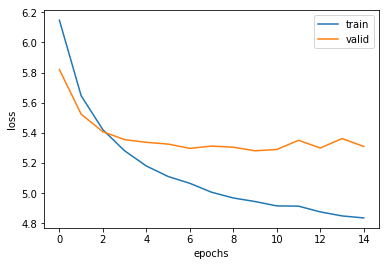

In [28]:
plot_losses()
evaluate(learner)

Loading model...
Tied weights
Running LR_find...


 71%|███████   | 231/326 [00:32<00:13,  7.08it/s, loss=44.5]

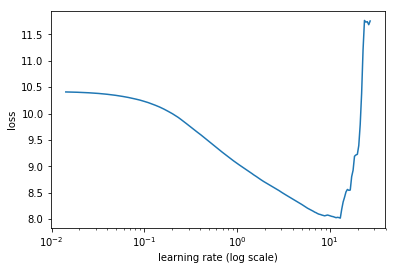

In [30]:
learner = run_LR_find(nlevels=2)

### To do: 
- set up script to run experiments (use python fire)
- message Sylvain 